# Explore logistic regression classification of 5,8 digits   
2017-11-27 Jeff Fessler, University of Michigan <br>
2018-11-27 Steven Whitaker - Convert to Julia v1.0 <br>
2019-11-25 Caroline Crockett - Add comments and sections, function template for NGD

This task sheet illustrates how to use three classification methods: subspace-based classification, least-squares based classification, and logistic regression classification (least-squares and logistic are both regression-type classifiers)
for classifying handwritten digits. We focus on the two digits “5” and “8” here because those digits are harder
to distinguish so they benefit from the methods explored here. The principles generalize to all digits.

In [1]:
using Plots, LinearAlgebra

### Task 0: Download and shape data

In [2]:
# read the MNIST data file for digits 5 and 8
# download from web if needed
file0 = "data5"
file1 = "data8"
if !isfile(file0)
    download("http://cis.jhu.edu/~sachin/digit/$file0", file0)
end
if !isfile(file1)
    download("http://cis.jhu.edu/~sachin/digit/$file1", file1)
end

nx = 28 # original image size
ny = 28
nrep = 1000

x0 = Array{UInt8}(undef, (nx,ny,nrep))
read!(file0, x0)

x1 = Array{UInt8}(undef, (nx,ny,nrep))
read!(file1, x1)

iy = 2:ny
x0 = x0[:,iy,:] # make images non-square to help debug
x1 = x1[:,iy,:]
ny = length(iy)

# Convert images to Float32 to avoid overflow errors
x0 = Array{Float32}(x0)
x1 = Array{Float32}(x1)

@show size(x0);
@show size(x1);

size(x0) = (28, 27, 1000)
size(x1) = (28, 27, 1000)


In [3]:
# function to display a 2d image
jim = (x; mx=size(x,1), my=size(x,2)) ->
    heatmap(1:size(x,1), 1:size(x,2), x,
        xtick=[1,mx], ytick=[1,my], yflip=true,
        color=:grays, transpose=true, aspect_ratio=1)
# function to display mosaic of multiple images
imshow3 = (x) -> begin
    tmp = permutedims(x, [1, 3, 2])
    tmp = reshape(tmp, :, ny)
    jim(tmp, mx=nx, my=ny)
end;

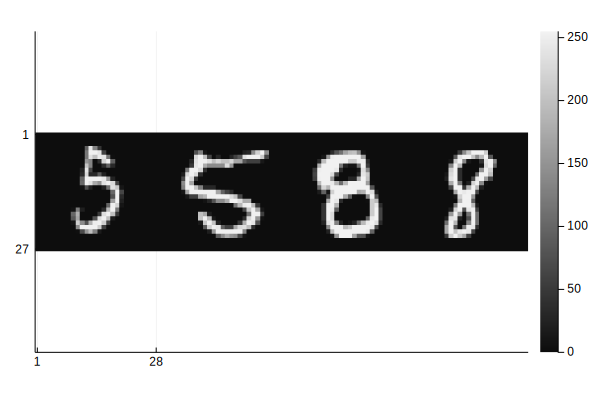

In [4]:
# look at a couple of the images
imshow3(cat(x0[:,:,44:45], x1[:,:,654:655], dims = 3))

In [5]:
# use some data for training, and some for test
ntrain = 100
ntest = nrep - ntrain
train0 = x0[:,:,1:ntrain] # training data
train1 = x1[:,:,1:ntrain]
test0 = x0[:,:,(ntrain+1):end] # testing data
test1 = x1[:,:,(ntrain+1):end];

## Task 1: Subspace based classification
This first part of the notebook is the subspace based classification method that you've previously coded. Now we apply that method to the digits 5 and 8. Run all the cells under Task 1 and report the classification accuracies in your document. If everything is working properly, both accuracies should be between 86% and 92%.

Note: you do not have to modify any code since this task is replicating code from a previous assignment, but we are now applying it to the digits 5 and 8 to see how well it does. 

In [6]:
# Use training data to estimate the subspaces
u0, s0, _ = svd(reshape(train0, nx*ny, :))
u1, s1, _ = svd(reshape(train1, nx*ny, :))

# Examine the scree plots to choose a rank!
plot(1:ntrain, s0, line=(:dots, :blue), label="$file0")
plot!(1:ntrain, s1, line=(:dots,:red), label="$file1")

size(s0)


(100,)

In [7]:
# Estimate subspaces for each digit class from training data
r0 = 3
r1 = 3
q0 = reshape(u0[:,1:r0], nx, ny, :)
q1 = reshape(u1[:,1:r0], nx, ny, :);
size(q0)


(28, 27, 3)

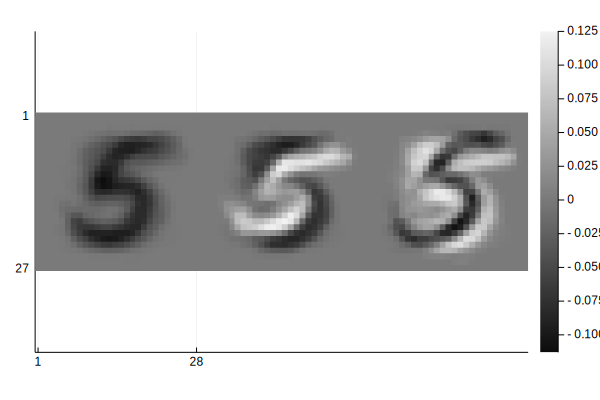

In [8]:
# show images of the 1st 3 components of first digit subspace
imshow3(q0[:,:,1:3])

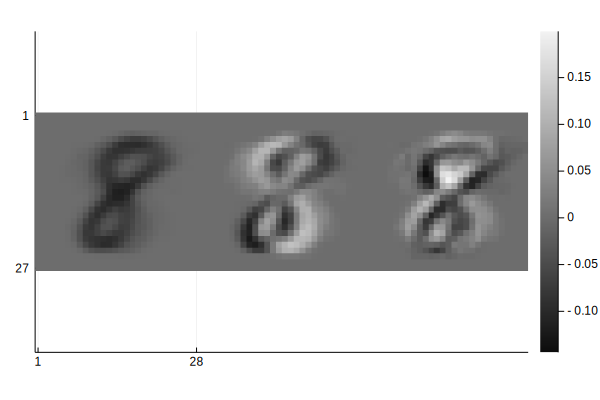

In [9]:
# show images of the 1st 3 components of second digit subspace
imshow3(q1[:,:,1:3])

In [10]:
# Classify all the test data based on your subspace estimates
# and count number of misclassified digits
# reshape() and norm() and mapslices() probably useful here

Q0 = reshape(q0, nx*ny, r0)
Q1 = reshape(q1, nx*ny, r1)

y0 = reshape(test0, nx*ny, :)
y00 = y0 - Q0*(Q0'*y0)
y01 = y0 - Q1*(Q1'*y0)
correct0 = (mapslices(norm, y00, dims = 1) .< mapslices(norm, y01, dims = 1))[:]
@show sum(correct0) / ntest;

y1 = reshape(test1, nx*ny, :)
y10 = y1 - Q0*(Q0'*y1)
y11 = y1 - Q1*(Q1'*y1)
correct1 = (mapslices(norm, y10, dims = 1) .> mapslices(norm, y11, dims = 1))[:]
@show sum(correct1) / ntest;

sum(correct0) / ntest = 0.9111111111111111
sum(correct1) / ntest = 0.8744444444444445


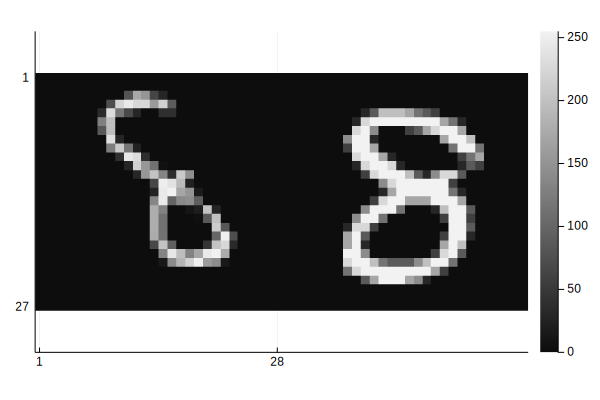

In [11]:
# show some bad cases
bad1 = findall(correct1 .== false)
imshow3(test1[:,:,bad1[1:2]])

## Task 2: least-squares based classifier 
This second part of the notebook is the least-squared based classification method that you've previously coded. Now we apply that method to the digits 5 and 8. Run all the cells under Task 2 and report the classification accuracies (for the test digits) in your document. If everything is working properly, both accuracies should be between 77% and 89%.

Note, you do not have to modify any code since this task is replicating code from a previous assignment, but now applying it to the digits 5 and 8.

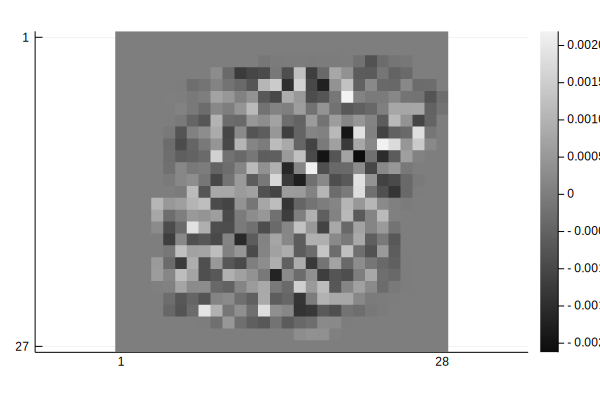

In [12]:
# LS-based classifier
A = cat(reshape(train0, :, ntrain)', reshape(train1, :, ntrain)', dims = 1)
b = [ones(ntrain); -ones(ntrain)] # this is the "RHS" for LS regression classifier
x_ls = A \ b
jim(reshape(x_ls, nx, ny)) # look at the LS regression coefficients

In [13]:
# assess the classification accuracy based on the LS coefficients 'x_ls'
ls_correct0 = sum(sign.(reshape(test0, nx*ny, :)' * x_ls) .== 1)
@show ls_correct0 / ntest
ls_correct1 = sum(sign.(reshape(test1, nx*ny, :)' * x_ls) .== -1)
@show ls_correct1 / ntest;

ls_correct0 / ntest = 0.8866666666666667
ls_correct1 / ntest = 0.7722222222222223


In [14]:
# LS works perfectly on (overfit!) training data!
tmp0 = sum(sign.(reshape(train0, nx*ny, :)' * x_ls) .== 1)
@show tmp0 / ntrain
tmp1 = sum(sign.(reshape(train1, nx*ny, :)' * x_ls) .== -1)
@show tmp1 / ntrain;

tmp0 / ntrain = 1.0
tmp1 / ntrain = 1.0


Optional: try using Tikhonov regularization to see if you can improve the classification accuracy.


## Task 3
This task is the core part of the logistic regression classifier.
+ Following the course notes, form a training data matrix V that has 200 rows, where the rows
are multiplied by ±1 based on using a class label of -1 for digit 5 and class label +1 for digit 8 (in the notes, this matrix is called A)
+ Normalize each row of V to have unit norm.
+ Use the formula in the lecture notes to compute the Lipschitz constant for the logistic regression cost
function gradient for β = 0.01. Record the value of L in your report.
+ Implement Nesterov’s fast gradient descent (you may recycle some previous HW code) for the logistic
regression cost function with regularization parameter β = 0.01.

The logistic regression cost function is: <br>
$f(x) = \text{sum}_i h(y_i ⟨x,v_i⟩) + β/2 ||x||_2^2$ <br>
$f(x) = 1_M' h.(Vx)         + β/2 ||x||_2^2 $

Where $h(z) = log(1+e^{-z})$ and $V[i,:] = y_i v_i'$

In [15]:
# TODO: form V matrix using product of each feature v_i with y_i = ±1

V = zeros(200,756)
V[1:100,:] = -1 * (reshape(train0, nx*ny, :))'; #you complete this - it should have 200 rows
V[101:200,:] = 1 * (reshape(train1, nx*ny, :))'
V = V ./ sqrt.(sum(V.^2, dims = 2)) # normalize rows to unit norm
reg = 0.01; # choose regularization parameter manually for now

In [43]:
# TODO: fill in the Lipschitz constant and gradient function 

# set up for logistic regression
niter = 100
pot = (z) -> log(1 + exp(-z)) # logistic loss function (aka potential function)
cost = (x) -> sum(pot.(V * x)) + reg/2 * norm(x)^2 # overall cost function

dpot = (z) -> -1 / (exp(z) + 1) # its derivative
grad = (x) -> V'dpot.(V*x) + (reg*x)         # TODO - fill in the gradient of logistic regression cost (takes and and returns a vector)
L = ((1/4) * opnorm(V) * opnorm(V)) + reg # TODO - fill in the Lipshitz constant
@show(L) # should be between 23 and 24

L = 23.893112024627243


23.893112024627243

In [59]:
# TODO - complete this function; See HW 5 problem 7 for help


"""
``x, out = ngd(grad, x0; nIters::Int = 200, L::Real = 0, fun = (x, iter) -> 0)

Implementation of Nesterov's FGD (fast gradient descent),
given the gradient of the cost function

In:
- grad is a function that takes in x and calculates the gradient of the cost function with respect to x
- x0 is an initial point
Optional:
- nIters is the number of iterations
- L is the Lipschitz constant of the derivative of the cost function
- fun is a function to evaluate every iteration

Out: (x, out)
- x is the guess of the minimizer after running nIters iterations
- out is an Array of evaluations of the fun function
"""
function ngd(grad, x0; niter::Int = 200, L::Real = 0, fun = (x, iter) -> 0)

    # these lines initialize the output array to have the correct size/type
    fun_x0 = fun(x0, 0)
    out = similar(Array{typeof(fun_x0)}, niter+1)
    out[1] = fun_x0

    # set up some variables
    x = copy(x0)
    xold = copy(x0)
    told = 1
    z = x0;

    # run the FGD for niter iterations
    for iter=1:niter
        t = (1 + sqrt(1+(4*told*told)))/2
        x = xold - ((1/L)*grad(xold))
        z = x + ((told - 1)/t)*(x - xold)
        told = copy(t)
        xold = copy(x)
        out[iter+1] = fun(x, iter) # compute cost each iteration
    end

    return x, out
end


ngd

## Task 4: Test the LR classifier 
+ Run 100 iterations of FGD and display the final iterate xk for k = 100 by reshaping it into a 2D image-sized
array as shown in the notebook.
Include a picture of the weights in your report and a comment about at least one feature you notice of the weights. 
+ Plot the cost function versus iteration to see if FGD has converged in 100 iterations.
Include this plot in your report and a comment about whether or not FGD has converged. 
+ Use the logistic regression weights to classify the test data for the 5 and 8 digits. 
Report the classification accuracy in your document.
If it is working properly, this method should have the best classification accuracy of those used here.
+ Make histograms of the inner products {xˆ
0vm} for the test data using the xˆ from the LS method, and, in
a separate plot, the xˆ from the logistic regression method, to see how well separated the two distributions
(for 5 and for 8) are. Include those histograms in your report and comment on how the histograms relate to the classification accuracies.

In [60]:
# use the previously set up gradient and cost function to call the lsngd function 
x0 = zeros(nx*ny)
niter = 100
x_fgd, cost_fgd = ngd(grad, x0, niter = niter, L=L, fun = (x, iter) -> cost(x))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [138.62943611198907, 125.63327086378467, 115.35988874842644, 106.8590891887319, 99.7571203173927, 93.76020001868035, 88.64140141234614, 84.22643803582099, 80.38124850529715, 77.00211220751412  …  29.125999860455607, 28.98950333326556, 28.85512354481617, 28.722806025435375, 28.59249829407506, 28.464149765440204, 28.337711662353513, 28.213136933011512, 28.090380172813934, 27.96939755047168])

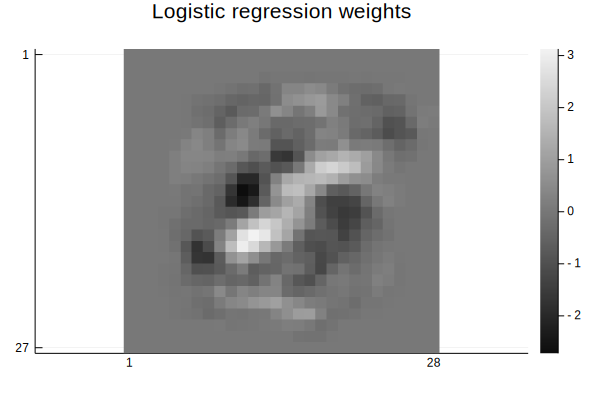

In [61]:
# examine classifier weights
jim(reshape(x_fgd, nx, ny))
title!("Logistic regression weights")
#savefig("lr_task4a_weights")

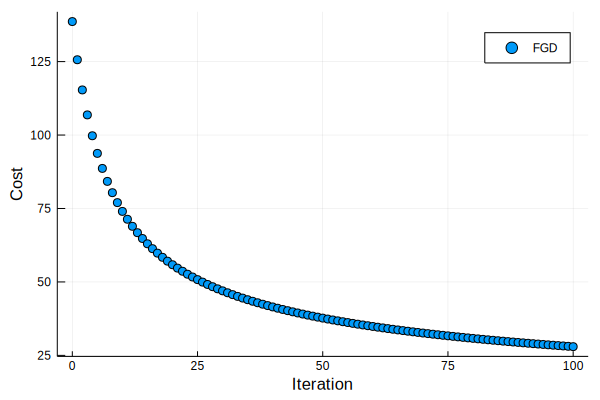

In [62]:
plot(0:niter, [cost_fgd[k][1] for k=1:niter+1], line=(:dots), label="FGD")
xlabel!("Iteration")
ylabel!("Cost")
#savefig("lr_task4b_cost")

In [63]:
# logistic regression based classification
log_correct0 = sum(sign.(reshape(test0, nx*ny, :)' * x_fgd) .== -1)
@show log_correct0 / ntest
log_correct1 = sum(sign.(reshape(test1, nx*ny, :)' * x_fgd) .== 1)
@show log_correct1 / ntest;

log_correct0 / ntest = 0.9633333333333334
log_correct1 / ntest = 0.8877777777777778


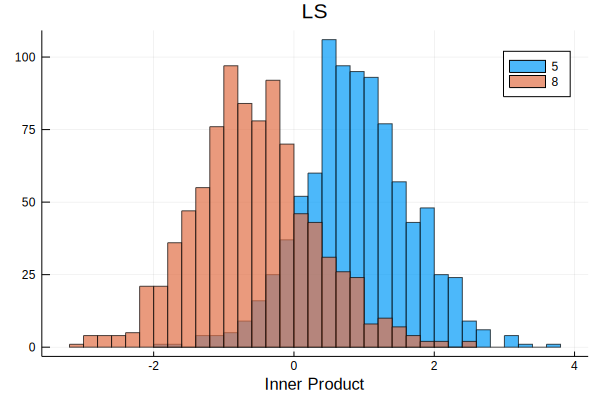

In [64]:
# histogram of inner products - LS
histogram(reshape(test0, nx*ny, :)' * x_ls, title = "LS", xlabel = "Inner Product", label = "5", alpha = 0.7, nbins = 30)
histogram!(reshape(test1, nx*ny, :)' * x_ls, label = "8", alpha = 0.7, nbins = 30)
#savefig("lr_task4d_histLS")

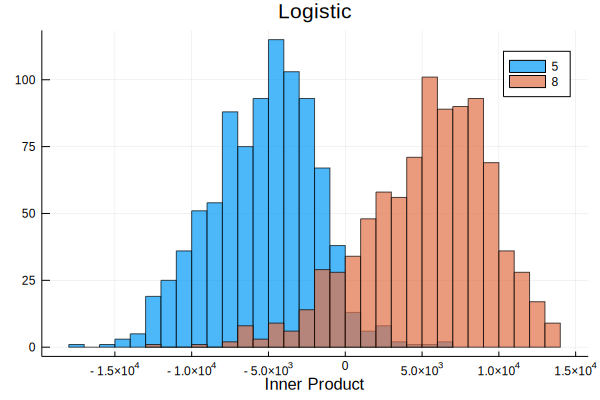

In [65]:
# histogram of inner products - logistic
histogram(reshape(test0, nx*ny, :)' * x_fgd, title = "Logistic", xlabel = "Inner Product", label = "5", alpha = 0.7, nbins = 30)
histogram!(reshape(test1, nx*ny, :)' * x_fgd, label = "8", alpha = 0.7, nbins = 30)
#savefig("lr_task4d_histLog")

## Optional extensions
+ Investigate different regularization parameters β. Do not use all of the test data for tuning that parameter,
otherwise you are essentially training with the test data! Instead, use, say, 100 samples for tuning β, and
then test with the remaining “untouched” 800 images.
+ Use this web tool to capture your own “hand-written” digit:
http://web.eecs.umich.edu/~fessler/course/551/r/digitdraw.htm and save it as a JPG file. (On
my Mac this worked for Safari but not on Chrome, so try another browser if your first try fails.)
Read that image into Julia (or Matlab) and down-size it to be the appropriate size for your digit
classifier. Apply your classifier and see if it identifies the correct digit.